In [22]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [ ]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出，设置最大容量

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))  # 将转移元组作为一个整体添加到缓冲区

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)  # 随机采样指定数量的转移元组
        state, action, reward, next_state, done = zip(*transitions)  # 解压所有转移元组，按类型分组
        return np.array(state), action, reward, np.array(next_state), done  # 返回批量数据，状态数据转换为numpy数组

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)  # 返回当前缓冲区中的样本数量

In [24]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [ ]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim  # 动作空间维度
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # 创建主Q网络并移至指定设备
        # 创建目标网络并移至指定设备
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器，优化主Q网络的参数
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子，用于计算未来奖励的现值
        self.epsilon = epsilon  # epsilon-贪婪策略的探索率
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器，记录更新次数，用于确定何时更新目标网络
        self.device = device  # 计算设备（CPU或GPU）

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:  # 以epsilon的概率随机选择动作（探索）
            action = np.random.randint(self.action_dim)  # 随机选择一个动作
        else:  # 以1-epsilon的概率选择当前最优动作（利用）
            if isinstance(state, tuple):  # 检查状态是否为元组
                state = state[0]  # 如果state是元组，提取第一个元素
            state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(self.device)  # 将状态转换为张量并添加batch维度
            action = self.q_net(state).argmax().item()  # 选择Q值最大的动作
        return action  # 返回选择的动作

    def update(self, transition_dict):  # 更新Q网络
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)  # 将状态转换为张量并移至设备
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)  # 将动作转换为张量并调整形状
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)  # 将奖励转换为张量并调整形状
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)  # 将下一状态转换为张量并移至设备
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)  # 将终止标志转换为张量并调整形状

        q_values = self.q_net(states).gather(1, actions)  # 获取当前状态-动作对的Q值
        # 计算下一状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # 计算TD目标值
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 计算均方误差损失
        self.optimizer.zero_grad()  # 清除之前的梯度
        dqn_loss.backward()  # 反向传播计算梯度
        self.optimizer.step()  # 更新网络参数

        if self.count % self.target_update == 0:  # 每隔target_update次更新目标网络
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 将主网络的参数复制到目标网络
        self.count += 1  # 更新计数器

In [26]:
# transition_dict['states'][0]

In [27]:
# states = torch.tensor(transition_dict['states'],
#                               dtype=torch.float)
# states.shape

In [ ]:
lr = 2e-3  # 设置学习率
num_episodes = 500  # 设置总训练回合数
hidden_dim = 128  # 设置神经网络隐藏层维度
gamma = 0.98  # 设置折扣因子
epsilon = 0.01  # 设置探索率
target_update = 10  # 设置目标网络更新频率
buffer_size = 10000  # 设置经验回放缓冲区大小
minimal_size = 500  # 设置开始训练的最小缓冲区大小
batch_size = 64  # 设置批量大小
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")  # 设置计算设备，优先使用GPU

env_name = 'CartPole-v0'  # 设置环境名称
env = gym.make(env_name)  # 创建OpenAI Gym环境
random.seed(0)  # 设置随机种子
np.random.seed(0)  # 设置numpy随机种子
env.reset(seed=0)  # 重置环境并设置环境随机种子

torch.manual_seed(0)  # 设置PyTorch随机种子
replay_buffer = ReplayBuffer(buffer_size)  # 创建经验回放缓冲区
state_dim = env.observation_space.shape[0]  # 获取状态空间维度
action_dim = env.action_space.n  # 获取动作空间维度
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)  # 创建DQN智能体

return_list = []  # 创建存储每个回合回报的列表
for i in range(10):  # 将总回合分为10组进行训练
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:  # 创建进度条
        for i_episode in range(int(num_episodes / 10)):  # 每组训练num_episodes/10个回合
            episode_return = 0  # 初始化当前回合的累积回报
            state,_ = env.reset()  # 重置环境，获取初始状态
            done = False  # 初始化回合结束标志
            while not done:  # 当回合未结束时循环
                action = agent.take_action(state)  # 智能体根据当前状态选择动作
                next_state, reward, done, _,_ = env.step(action)  # 执行动作，获取下一状态、奖励和是否结束
                replay_buffer.add(state, action, reward, next_state, done)  # 将转移元组添加到经验回放缓冲区
                state = next_state  # 更新当前状态
                episode_return += reward  # 累加奖励
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:  # 当缓冲区大小超过最小值时开始训练
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)  # 从缓冲区采样一批数据
                    transition_dict = {  # 创建转移字典
                        'states': b_s,  # 状态
                        'actions': b_a,  # 动作
                        'next_states': b_ns,  # 下一状态
                        'rewards': b_r,  # 奖励
                        'dones': b_d  # 是否结束
                    }
                    agent.update(transition_dict)  # 更新智能体的Q网络
            return_list.append(episode_return)  # 将当前回合的累积回报添加到列表中
            if (i_episode + 1) % 10 == 0:  # 每10个回合更新一次进度条信息
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),  # 显示当前回合数
                    'return':
                    '%.3f' % np.mean(return_list[-10:])  # 显示最近10个回合的平均回报
                })
            pbar.update(1)  # 更新进度条

C:\Program Files\Python312\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]C:\Program Files\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 9: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s, episode=500, return=375.800]


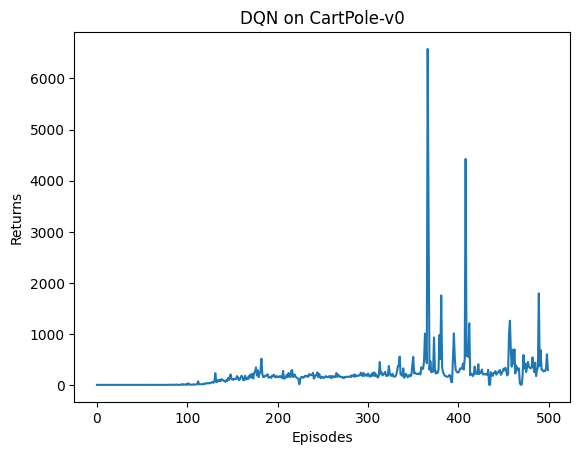

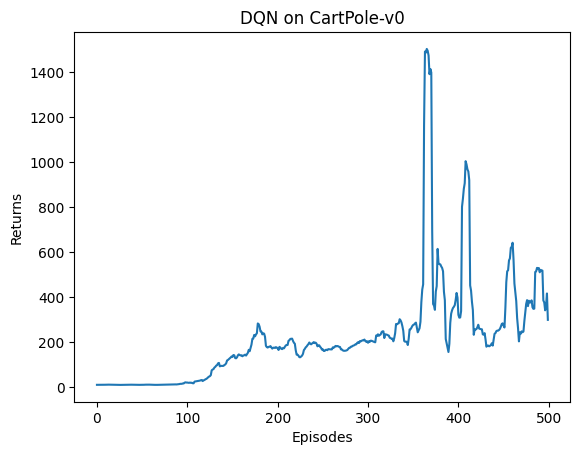

In [29]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()